In [1]:
import re
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

In [2]:
#Load Dataset
QUICK_MODE = True #grid parameter kecil untuk mempercepat training
DATA_PATH = "D:\MyProject\FinanceAI\dataset\dataset_keuangan.csv"
OUT_DIR = "D:\MyProject\FinanceAI\model"

In [3]:
# cleaning teks di dataset
def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r'\b(\d+[\d\.,]*)\b', ' <NUM> ', s)
    s = re.sub(r'\b(ribu|rb|k|jt|juta)\b', ' <NUM> ', s) #ubah kata ribu, rb, jt, juta dan sebagainya menjadi nominal
    s = re.sub(r'[^a-z0-9<> ]+', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

In [4]:
def print_metrics(y_true, y_pred, y_score=None, label_names=["pengeluaran","pemasukan"]): #fungsi buat menghitung seberapa akurat mode mengelompokkan pemasukan dan pengeluaran
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)    
    rec = recall_score(y_true, y_pred)    
    f1 = f1_score(y_true, y_pred)    
    print("Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f} | F1: {:.4f}".format(acc, prec, rec, f1)) # hasil metrik akurasi, precision, recall, dan F1-score dari var acc, prec rec f1  
    #kalau ada probabilitas prediksi (y_score), hitung nilai ROC-AUC
    if y_score is not None:
        try:
            auc = roc_auc_score(y_true, y_score)  # Mengukur seberapa baik model membedakan kelas
            print("ROC-AUC: {:.4f}".format(auc))
        except Exception:
            pass
    
    # Menampilkan classification report (precision, recall, f1, support per kelas)
    print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=label_names, digits=4))
    
    # Menampilkan confusion matrix (jumlah prediksi benar dan salah antar kelas)
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


In [5]:
def plot_confusion(cm, title="Confusion matrix", labels=["pengeluaran","pemasukan"]): #fungsi nampilinconfusion matrix  buat analisis performa model klasifikasi
    fig = plt.figure(figsize=(4,3))
    plt.imshow(cm)
    plt.title(title)    
    plt.xlabel("Predicted")    
    plt.ylabel("Actual")    
    plt.xticks([0,1], labels)
    plt.yticks([0,1], labels)  
    # np.ndenumerate(cm) memberi pasangan index (i,j) dan value dari matrix
    for (i, j), val in np.ndenumerate(cm):
        plt.text(j, i, int(val), ha="center", va="center")  
    plt.tight_layout()    
    plt.show()


In [6]:
df = pd.read_csv(DATA_PATH) # pastikan dataset ada
df = df.dropna(subset=["kalimat", "label"]).reset_index(drop=True) #cek missing value dan autodrop kalau ada
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # ngacak urutan baris DataFrame (agar training lebih fair)
df.head()

,kalimat,label
0,membeli 2jt,pengeluaran
1,keluar duit 100k,pengeluaran
2,50.000 dari orang tua sebagai menang,pemasukan
3,duit masuk 1 juta,pemasukan
4,duit masuk 5000,pemasukan


In [7]:
label_map = {"pengeluaran":0, "pemasukan":1} #mapping label pengeluaran dan pemasukan
df["y"] = df["label"].map(label_map)
df["text_clean"] = df["kalimat"].apply(clean_text)

print("Total rows:", len(df))
print(df["label"].value_counts())

Total rows: 10000
label
pengeluaran    5000
pemasukan      5000
Name: count, dtype: int64


In [8]:
X = df["text_clean"].values
y = df["y"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) #Membagi dataset menjadi data latih (train) dan data uji (test)

In [9]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=20000) # Membuat vectorizer TF-IDF untuk mengubah teks menjadi fitur numerik

pipelines = { # kumpulan pipeline model dengan kombinasi TF-IDF + classifier
    "LogisticRegression": Pipeline([("tfidf", tfidf), ("clf", LogisticRegression(C=1.0, class_weight="balanced", max_iter=2000, solver="saga", random_state=42))]),
    "LinearSVC": Pipeline([("tfidf", tfidf), ("clf", LinearSVC(C=1.0, class_weight="balanced", max_iter=20000, random_state=42))]),
    "MultinomialNB": Pipeline([("tfidf", tfidf), ("clf", MultinomialNB(alpha=0.5))]),
    "RandomForest": Pipeline([("tfidf", tfidf), ("clf", RandomForestClassifier(n_estimators=100, max_depth=30, random_state=42, n_jobs=-1))]),
    "HistGradientBoosting": Pipeline([("tfidf", tfidf), ("clf", HistGradientBoostingClassifier(max_iter=100, random_state=42))])
} 


In [10]:
if QUICK_MODE:
    # smaller work set
    param_grids = {
        "LogisticRegression": {"clf__C":[0.3,1.0]},
        "LinearSVC": {"clf__C":[0.5,1.0]},
        "MultinomialNB": {"clf__alpha":[0.5,1.0]},
        "RandomForest": {"clf__n_estimators":[100], "clf__max_depth":[20,30]},
        "HistGradientBoosting": {"clf__max_iter":[100]}
    }
    cv_for_tuning = 3
else:
    param_grids = {
        "LogisticRegression": {"clf__C":[0.1,0.3,1.0,3.0], "clf__class_weight":[None,"balanced"]},
        "LinearSVC": {"clf__C":[0.1,0.5,1.0,3.0], "clf__class_weight":[None,"balanced"]},
        "MultinomialNB": {"clf__alpha":[0.1,0.5,1.0]},
        "RandomForest": {"clf__n_estimators":[100,200], "clf__max_depth":[None,20,30]},
        "HistGradientBoosting": {"clf__max_iter":[100,200]}
    }
    cv_for_tuning = 5


In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
summary_rows = []

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [12]:
for name, model in models.items(): # looping melakukan training, hyperparameter tuning , evaluasi, dan logging hasil untuk setiap model
    print("\n>>> Processing:", name)
    grid = param_grids.get(name, {})
    if grid: # Kalau ada grid, lakukan hyperparameter tuning GridSearchCV
        gs = GridSearchCV(model, grid, cv=cv_for_tuning, scoring="f1", n_jobs=1, verbose=1)
        gs.fit(X_train_vec, y_train)
        best_model = gs.best_estimator_
    else: #kalau tidak ada, atur proses defult
        best_model = model
        best_model.fit(X_train_vec, y_train)

    y_test_pred = best_model.predict(X_test_vec)
    y_test_score = None
    if hasattr(best_model, "predict_proba"): # kalau model punya metode predict_proba, mbil probabilitas kelas positif
        y_test_score = best_model.predict_proba(X_test_vec)[:, 1]
    elif hasattr(best_model, "decision_function"): # kalau model punya decision_function → ambil skor decision
        y_test_score = best_model.decision_function(X_test_vec)

# Hitung metrik evaluasi pada test set
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    auc = roc_auc_score(y_test, y_test_score) if y_test_score is not None else np.nan

    print_metrics(y_test, y_test_pred, y_score=y_test_score)

    # cross-validated predictions on train (diagnostics)
    y_cv_pred = cross_val_predict(best_model, X_train_vec, y_train, cv=cv, method="predict", n_jobs=1)
    f1_cv = f1_score(y_train, y_cv_pred)
    print("CV (train) F1:", f1_cv)

# Simpan hasil evaluasi ke summary_rows (untuk perbandingan antar model)
    summary_rows.append({
        "model": name, "test_accuracy": acc, "test_precision": prec, "test_recall": rec, "test_f1": f1, "test_roc_auc": auc,
        "cv_train_f1": f1_cv, "pipeline": best_model
    })


>>> Processing: Logistic Regression
Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
ROC-AUC: 1.0000

Classification report:
               precision    recall  f1-score   support

 pengeluaran     1.0000    1.0000    1.0000      1000
   pemasukan     1.0000    1.0000    1.0000      1000

    accuracy                         1.0000      2000
   macro avg     1.0000    1.0000    1.0000      2000
weighted avg     1.0000    1.0000    1.0000      2000

Confusion matrix:
 [[1000    0]
 [   0 1000]]
CV (train) F1: 1.0

>>> Processing: Random Forest
Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
ROC-AUC: 1.0000

Classification report:
               precision    recall  f1-score   support

 pengeluaran     1.0000    1.0000    1.0000      1000
   pemasukan     1.0000    1.0000    1.0000      1000

    accuracy                         1.0000      2000
   macro avg     1.0000    1.0000    1.0000      2000
weighted avg     1.0000    1.0000    1.0000      200

In [13]:
summary_df = pd.DataFrame(summary_rows).sort_values(by="test_f1", ascending=False).reset_index(drop=True)
print(" Perbandingan setiap model:")
display(summary_df[["model","test_accuracy","test_precision","test_recall","test_f1","test_roc_auc","cv_train_f1"]])

 Perbandingan setiap model:


,model,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,cv_train_f1
0,Logistic Regression,1.0,1.0,1.0,1.0,1.0,1.0
1,Random Forest,1.0,1.0,1.0,1.0,1.0,1.0
2,SVM,1.0,1.0,1.0,1.0,1.0,1.0


In [14]:
#pengambilan model terbaik berdasarkan rata-rata skor ukuran data dan learning curve
best_pipeline = summary_df.loc[0, "pipeline"]
best_name = summary_df.loc[0, "model"]
print("Best model:", best_name) 
train_sizes, train_scores, test_scores = learning_curve(best_pipeline, X_train_vec, y_train, cv=5, train_sizes=np.linspace(0.1,1.0,5), scoring="f1", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

Best model: Logistic Regression


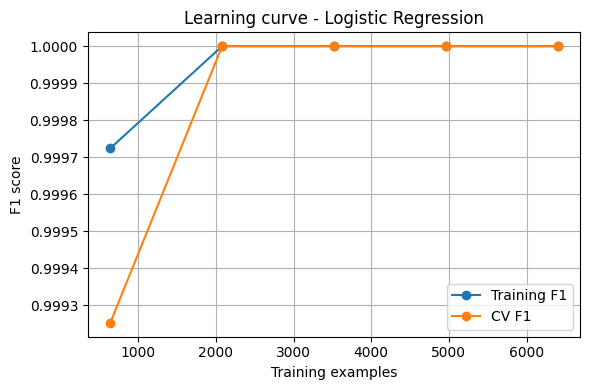

In [15]:
plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_scores_mean, marker='o', label="Training F1")
plt.plot(train_sizes, test_scores_mean, marker='o', label="CV F1")
plt.xlabel("Training examples")
plt.ylabel("F1 score")
plt.title(f"Learning curve - {best_name}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

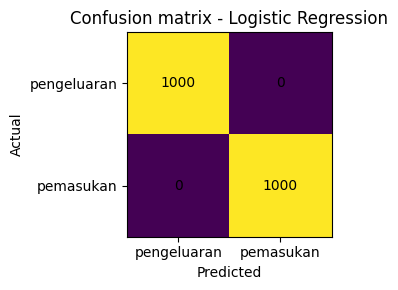

In [16]:
y_best_test_pred = best_pipeline.predict(X_test_vec)
cm = confusion_matrix(y_test, y_best_test_pred)
plot_confusion(cm, title=f"Confusion matrix - {best_name}")

In [17]:
# Mengambil model terbaik 
best_model = summary_df.loc[0, "pipeline"]

# simpan vectorizer dan model dalam bentuk terpisah
vectorizer_path = Path(OUT_DIR) / "tfidf_vectorizer.joblib"
model_path = Path(OUT_DIR) / "best_classifier.joblib"

joblib.dump(vectorizer, vectorizer_path)
joblib.dump(best_model, model_path)

print(f"Vectorizer berhasil disimpan")
print(f"Model classifier berhasil disimpan")

Vectorizer berhasil disimpan
Model classifier berhasil disimpan


In [18]:
vectorizer_path = f"{OUT_DIR}/tfidf_vectorizer.joblib"
model_path = f"{OUT_DIR}/best_classifier.joblib"

try:
    loaded_vectorizer = joblib.load(vectorizer_path)
    loaded_model = joblib.load(model_path)
    print("Vectorizer dan model berhasil dimuat.")
except FileNotFoundError as e:
    print(f"Error: File tidak ditemukan.")
    exit()

# tes model dengan input kalimat baru
kalimat = [
    "gaji an 5 juta",
    "Kemarin aku beli kopi harganya 25 ribu.",
    "nemu uang di jalan 20k",
    "Pengeluaran bulan ini untuk bayar tagihan listrik dan internet.",
    "Menerima bonus akhir tahun dari kantor."
]

# bersihin teks dan ubah jadi vektir numerik dengan vectorizer yang di simpan tadi
kalimat_clean = [clean_text(k) for k in kalimat]
kalimat_vec = loaded_vectorizer.transform(kalimat_clean)

# prediksi dengan model 
prediksi = loaded_model.predict(kalimat_vec)
prediksi_proba = loaded_model.predict_proba(kalimat_vec)

label_map_inverse = {0: "pengeluaran", 1: "pemasukan"}
hasil_prediksi = [label_map_inverse[p] for p in prediksi]

print("--- Hasil Prediksi pada Kalimat Baru ---")
for i, kalimat in enumerate(kalimat):
    label = hasil_prediksi[i]
    confidence = prediksi_proba[i].max() * 100
    print(f"\nKalimat: '{kalimat}'")
    print(f"Prediksi: {label.upper()} (Confidence: {confidence:.2f}%)")


Vectorizer dan model berhasil dimuat.
--- Hasil Prediksi pada Kalimat Baru ---

Kalimat: 'gaji an 5 juta'
Prediksi: PEMASUKAN (Confidence: 95.85%)

Kalimat: 'Kemarin aku beli kopi harganya 25 ribu.'
Prediksi: PENGELUARAN (Confidence: 96.72%)

Kalimat: 'nemu uang di jalan 20k'
Prediksi: PEMASUKAN (Confidence: 74.34%)

Kalimat: 'Pengeluaran bulan ini untuk bayar tagihan listrik dan internet.'
Prediksi: PENGELUARAN (Confidence: 99.78%)

Kalimat: 'Menerima bonus akhir tahun dari kantor.'
Prediksi: PEMASUKAN (Confidence: 99.70%)
